# Introduction

Baseline experiment

# Set up Environment

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from math import sqrt
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score,
                             explained_variance_score)

# display all columns of dataframes in the notebook
pd.options.display.max_columns = None

# ignore warnings
warnings.filterwarnings('ignore')

# set up random seed for reproducibility
RANDOM_SEED = 42

# Load Data

In [3]:
file_path = '../data/raw/training_data/'
file_name = 'training_data_ATL.zip'
df = pd.read_csv(file_path + file_name)

# Pre-process

## Remove Irrelevant Columns

In [4]:
# remove the Unnamed column
df.drop(df.columns[df.columns.str.contains(
    'unnamed', case=False)], axis=1, inplace=True)

In [5]:
df.head(3)

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,DOT_ID_Reporting_Airline,IATA_CODE_Reporting_Airline,Tail_Number,Flight_Number_Reporting_Airline,OriginAirportID,OriginAirportSeqID,OriginCityMarketID,Origin,OriginCityName,OriginState,OriginStateFips,OriginStateName,OriginWac,DestAirportID,DestAirportSeqID,DestCityMarketID,Dest,DestCityName,DestState,DestStateFips,DestStateName,DestWac,CRSDepTime,DepTime,DepDelay,DepDelayMinutes,DepDel15,DepartureDelayGroups,DepTimeBlk,TaxiOut,WheelsOff,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelay,ArrDelayMinutes,ArrDel15,ArrivalDelayGroups,ArrTimeBlk,CRSElapsedTime,ActualElapsedTime,AirTime,Flights,Distance,DistanceGroup,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,ArrivalDate,ARR_Flight_SLDT,Num_Arr_SLDT-30,Num_Arr_SLDT-25,Num_Arr_SLDT-20,Num_Arr_SLDT-15,Num_Arr_SLDT-10,Num_Arr_SLDT-5,Num_Arr_SLDT-0,Num_Arr_SLDT+5,Num_Arr_SLDT+10,Num_Arr_SLDT+15,Num_Arr_SLDT+20,Num_Arr_SLDT+25,Num_Dep_SLDT-30,Num_Dep_SLDT-25,Num_Dep_SLDT-20,Num_Dep_SLDT-15,Num_Dep_SLDT-10,Num_Dep_SLDT-5,Num_Dep_SLDT-0,Num_Dep_SLDT+5,Num_Dep_SLDT+10,Num_Dep_SLDT+15,Num_Dep_SLDT+20,Num_Dep_SLDT+25
0,2017,1,1,1,7,2017-01-01 00:00:00,AA,19805,AA,N869AA,232,11298,1129804,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,74,10397,1039705,30397,ATL,"Atlanta, GA",GA,13,Georgia,34,14:25:00,1430.0,5.0,5.0,0.0,0.0,1400-1459,12.0,1442.0,1717.0,10.0,17:26:00,1727.0,1.0,1.0,0.0,0.0,1700-1759,121.0,117.0,95.0,1.0,731.0,3,NaN,NaN,NaN,NaN,NaN,2017-01-01 00:00:00,2017-01-01 17:26:00,9,9,12,3,7,0,2,3,2,5,1,3,3,2,0,3,7,0,3,2,1,9,3,5
1,2017,1,1,2,1,2017-01-02 00:00:00,AA,19805,AA,N866AA,232,11298,1129804,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,74,10397,1039705,30397,ATL,"Atlanta, GA",GA,13,Georgia,34,14:25:00,1420.0,-5.0,0.0,0.0,-1.0,1400-1459,13.0,1433.0,1723.0,11.0,17:26:00,1734.0,8.0,8.0,0.0,0.0,1700-1759,121.0,134.0,110.0,1.0,731.0,3,NaN,NaN,NaN,NaN,NaN,2017-01-02 00:00:00,2017-01-02 17:26:00,6,8,9,4,10,0,2,1,5,4,2,2,6,3,1,4,8,0,3,2,4,11,6,3
2,2017,1,1,3,2,2017-01-03 00:00:00,AA,19805,AA,N897AA,232,11298,1129804,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,74,10397,1039705,30397,ATL,"Atlanta, GA",GA,13,Georgia,34,14:25:00,1426.0,1.0,1.0,0.0,0.0,1400-1459,14.0,1440.0,1718.0,5.0,17:26:00,1723.0,-3.0,0.0,0.0,-1.0,1700-1759,121.0,117.0,98.0,1.0,731.0,3,NaN,NaN,NaN,NaN,NaN,2017-01-03 00:00:00,2017-01-03 17:26:00,6,10,9,3,8,0,2,1,4,4,4,2,5,2,0,4,5,0,3,2,4,14,7,4


In [6]:
df.shape

(744979, 84)

Airport traffic data are stored in the last 24 columns of df. We want to select only the first 60 columns for EDA.

In [7]:
arrivals = df.iloc[:, 0:60].copy()

In [8]:
arrivals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744979 entries, 0 to 744978
Data columns (total 60 columns):
Year                               744979 non-null int64
Quarter                            744979 non-null int64
Month                              744979 non-null int64
DayofMonth                         744979 non-null int64
DayOfWeek                          744979 non-null int64
FlightDate                         744979 non-null object
Reporting_Airline                  744979 non-null object
DOT_ID_Reporting_Airline           744979 non-null int64
IATA_CODE_Reporting_Airline        744979 non-null object
Tail_Number                        744979 non-null object
Flight_Number_Reporting_Airline    744979 non-null int64
OriginAirportID                    744979 non-null int64
OriginAirportSeqID                 744979 non-null int64
OriginCityMarketID                 744979 non-null int64
Origin                             744979 non-null object
OriginCityName               

In [31]:
# obtain a segment of arrivals (intersted columns)
segment = arrivals[['ActualElapsedTime', 'FlightDate', 'ArrivalDate', 'Reporting_Airline', 'CRSDepTime',
                    'DepTime', 'DepDelay', 'DepDel15', 'DepartureDelayGroups', 'CRSArrTime',
                    'CRSElapsedTime', 'Distance', 'DistanceGroup']]

In [32]:
# rename some column names
segment = segment.rename(columns={'ActualElapsedTime':'AOBTtoAIBT',
                                  'FlightDate': 'SOBTDate',
                                  'ArrivalDate': 'SIBTDate',
                                  'Reporting_Airline': 'UniqueCarrierCode',
                                  'CRSDepTime': 'SOBTTime',
                                  'DepTime': 'AOBTTime',
                                  'DepDelay': 'OBTDelay',
                                  'DepDel15': 'OBTDel15',
                                  'DepartureDelayGroups': 'OBTDelayGroups',
                                  'CRSArrTime': 'SIBTTime',
                                  'CRSElapsedTime': 'SOBTtoSIBT',
                                 })

## Format Datetime Objects

In [33]:
segment['SOBTDate'] = pd.to_datetime(segment['SOBTDate']).dt.date
segment['SIBTDate'] = pd.to_datetime(segment['SIBTDate']).dt.date
segment['SOBTTime'] = pd.to_datetime(
    segment['SOBTTime'], format='%H:%M:%S').dt.time
segment['SIBTTime'] = pd.to_datetime(
    segment['SIBTTime'], format='%H:%M:%S').dt.time

In [34]:
# format AOBTTime
segment['AOBTTime'] = segment['AOBTTime'].apply(lambda x: str(int(x)).zfill(4))

# for actual timings, '2400' would be produced when the date changed to the next day
# for e.g., 2400 1 Jan is actually equivalent to 0000 2 Jan

In [35]:
print('Number of AOBTTime being "2400":',
      segment[segment['AOBTTime'] == '2400'].shape[0])

Number of AOBTTime being "2400": 60


In [36]:
one_day = pd.Timedelta('1 days')

# Initialize AOBTDate
segment['AOBTDate'] = segment['SOBTDate']

# if 2400 occurs, add 1 day to AOBTDate
segment.loc[segment.AOBTTime == '2400',
            "AOBTDate"] = segment['AOBTDate'] + one_day

# update AOBTTime from '2400' to '0000'
segment.loc[segment.AOBTTime == '2400', "AOBTTime"] = '0000'

In [37]:
# now the issue of '2400' is resolved
# update AOBTTime to time object
segment['AOBTTime'] = pd.to_datetime(segment['AOBTTime'], format='%H%M').dt.time

In [38]:
# merge date & time, and only keep datetime objects
list_1 = ['SOBTDate', 'SIBTDate', 'AOBTDate']
list_2 = ['SOBTTime', 'SIBTTime', 'AOBTTime']
list_3 = ['SOBT', 'SIBT', 'AOBT']

for i in range(3):
    segment[list_1[i]] = segment[list_1[i]].apply(lambda x: str(x))
    segment[list_2[i]] = segment[list_2[i]].apply(lambda x: str(x))
    segment[list_3[i]] = pd.to_datetime(
        segment[list_1[i]] + ' ' + segment[list_2[i]])
    segment = segment.drop(labels=[list_1[i], list_2[i]], axis=1)

In [39]:
segment.head(3)

,AOBTtoAIBT,UniqueCarrierCode,OBTDelay,OBTDel15,OBTDelayGroups,SOBTtoSIBT,Distance,DistanceGroup,SOBT,SIBT,AOBT
0,117.0,AA,5.0,0.0,0.0,121.0,731.0,3,2017-01-01 14:25:00,2017-01-01 17:26:00,2017-01-01 14:30:00
1,134.0,AA,-5.0,0.0,-1.0,121.0,731.0,3,2017-01-02 14:25:00,2017-01-02 17:26:00,2017-01-02 14:20:00
2,117.0,AA,1.0,0.0,0.0,121.0,731.0,3,2017-01-03 14:25:00,2017-01-03 17:26:00,2017-01-03 14:26:00


## Create Time-related Features

In [40]:
# create Year, Quarter, Month, DayOfMonth, DayOfWeek based on SIBT (previously, SOBT)
segment['SIBTQuarter'] = segment['SIBT'].dt.quarter
segment['SIBTMonth'] = segment['SIBT'].dt.month
segment['SIBTDayOfMonth'] = segment['SIBT'].dt.day
segment['SIBTDayOfWeek'] = segment['SIBT'].dt.weekday + 1
segment['SIBTHour'] = segment['SIBT'].dt.hour

In [41]:
# there are 14 flights (from EDA) scheduled to arrive at ATL in 2019
# remove them as only arrival flights scheduled in 2017 and 2018 are of concern
segment = segment[segment['SIBT'].dt.year != 2019].reset_index(drop=True)

## Impute Missing Values

In [44]:
# find columns that contain null values
null_col = segment.columns[segment.isna().any()].tolist()

# find how many values are missing in each column
missing_count = pd.Series(segment[null_col].isna().sum(), name='Count')

# determine percentage of missing values
missing_percentage = pd.Series(
    np.round(segment[null_col].isnull().mean()*100, 3), name='Percentage')

missing_var_summary = pd.concat([missing_count, missing_percentage], axis=1)
missing_var_summary

,Count,Percentage
OBTDelay,460,0.062
OBTDel15,460,0.062
OBTDelayGroups,460,0.062


In [46]:
# handle missing OBTDelay
segment.loc[segment.OBTDelay.isnull(), "OBTDelay"] = (
    segment.AOBT - segment.SOBT).astype('timedelta64[m]')


def delayed_more_than_15(x):
    # handle missing OBTDel15
    if x >= 15:
        a = 1
    else:
        a = 0
    return a


segment['OBTDel15'] = segment['OBTDelay'].apply(
    lambda x: delayed_more_than_15(x))

# for all 460 entries, the OBTDelay is 0. Proved by:
# segment[segment['OBTDelayGroups'].isnull()]['OBTDelay'].unique()
# Hence, update missing OBTDelayGroups to be 0
segment.loc[segment.OBTDelayGroups.isnull(), "OBTDelayGroups"] = 0

In [47]:
segment.head(3)

,AOBTtoAIBT,UniqueCarrierCode,OBTDelay,OBTDel15,OBTDelayGroups,SOBTtoSIBT,Distance,DistanceGroup,SOBT,SIBT,AOBT,SIBTQuarter,SIBTMonth,SIBTDayOfMonth,SIBTDayOfWeek,SIBTHour
0,117.0,AA,5.0,0,0.0,121.0,731.0,3,2017-01-01 14:25:00,2017-01-01 17:26:00,2017-01-01 14:30:00,1,1,1,7,17
1,134.0,AA,-5.0,0,-1.0,121.0,731.0,3,2017-01-02 14:25:00,2017-01-02 17:26:00,2017-01-02 14:20:00,1,1,2,1,17
2,117.0,AA,1.0,0,0.0,121.0,731.0,3,2017-01-03 14:25:00,2017-01-03 17:26:00,2017-01-03 14:26:00,1,1,3,2,17


In [49]:
# format float to int
to_int = ['AOBTtoAIBT', 'OBTDelay', 'OBTDelayGroups', 'SOBTtoSIBT', 'Distance', 'DistanceGroup']

for item in to_int:
    segment[item] = segment[item].astype(int)

In [50]:
segment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744965 entries, 0 to 744964
Data columns (total 16 columns):
AOBTtoAIBT           744965 non-null int32
UniqueCarrierCode    744965 non-null object
OBTDelay             744965 non-null int32
OBTDel15             744965 non-null int64
OBTDelayGroups       744965 non-null int32
SOBTtoSIBT           744965 non-null int32
Distance             744965 non-null int32
DistanceGroup        744965 non-null int32
SOBT                 744965 non-null datetime64[ns]
SIBT                 744965 non-null datetime64[ns]
AOBT                 744965 non-null datetime64[ns]
SIBTQuarter          744965 non-null int64
SIBTMonth            744965 non-null int64
SIBTDayOfMonth       744965 non-null int64
SIBTDayOfWeek        744965 non-null int64
SIBTHour             744965 non-null int64
dtypes: datetime64[ns](3), int32(6), int64(6), object(1)
memory usage: 73.9+ MB


# Feature Engineering

In [58]:
flights = segment.copy()

# sort flights by SIBT
flights.sort_values('SIBT', inplace=True, ascending=True)
flights = flights.reset_index(drop=True)

In [52]:
flights.head(3)

,AOBTtoAIBT,UniqueCarrierCode,OBTDelay,OBTDel15,OBTDelayGroups,SOBTtoSIBT,Distance,DistanceGroup,SOBT,SIBT,AOBT,SIBTQuarter,SIBTMonth,SIBTDayOfMonth,SIBTDayOfWeek,SIBTHour
0,218,DL,-2,0,-1,223,1590,7,2017-01-01 00:55:00,2017-01-01 06:38:00,2017-01-01 00:53:00,1,1,1,7,6
1,81,F9,-4,0,-1,88,404,2,2017-01-01 05:15:00,2017-01-01 06:43:00,2017-01-01 05:11:00,1,1,1,7,6
2,88,EV,302,1,12,57,106,1,2017-01-01 05:49:00,2017-01-01 06:46:00,2017-01-01 10:51:00,1,1,1,7,6


In [59]:
flights = flights[['AOBTtoAIBT', 'UniqueCarrierCode', 'OBTDelay', 'OBTDel15', 'OBTDelayGroups', 'SOBTtoSIBT',
                   'Distance', 'DistanceGroup', 'SIBTQuarter', 'SIBTMonth', 'SIBTDayOfMonth', 'SIBTDayOfWeek',
                   'SIBTHour']]

In [60]:
flights.head()

,AOBTtoAIBT,UniqueCarrierCode,OBTDelay,OBTDel15,OBTDelayGroups,SOBTtoSIBT,Distance,DistanceGroup,SIBTQuarter,SIBTMonth,SIBTDayOfMonth,SIBTDayOfWeek,SIBTHour
0,218,DL,-2,0,-1,223,1590,7,1,1,1,7,6
1,81,F9,-4,0,-1,88,404,2,1,1,1,7,6
2,88,EV,302,1,12,57,106,1,1,1,1,7,6
3,111,DL,-2,0,-1,98,447,2,1,1,1,7,7
4,72,DL,-4,0,-1,76,226,1,1,1,1,7,7


## Separate Train and Validation Datasets

In [61]:
# the last 10000 flights are set as validation dataset
X_train, X_val, y_train, y_val = train_test_split(flights.iloc[:, 1:13],
                                                  flights['AOBTtoAIBT'],
                                                  shuffle=False,
                                                  test_size=10000)

X_train.shape, X_val.shape

((734965, 12), (10000, 12))

In [62]:
X_val.head(3)

,UniqueCarrierCode,OBTDelay,OBTDel15,OBTDelayGroups,SOBTtoSIBT,Distance,DistanceGroup,SIBTQuarter,SIBTMonth,SIBTDayOfMonth,SIBTDayOfWeek,SIBTHour
734965,DL,12,0,0,116,545,3,4,12,21,5,19
734966,DL,53,1,3,119,581,3,4,12,21,5,19
734967,9E,26,1,1,105,377,2,4,12,21,5,20


The validation set are flights after 2018-12-21 6pm.

## Categorical Variables

In [63]:
# capture categorical variables in a list
cat_vars = [var for var in X_train.columns if X_train[var].dtypes == 'O']

print('Number of categorical variables: ', len(cat_vars))
print(cat_vars)

Number of categorical variables:  1
['UniqueCarrierCode']


### Cardinality

In [64]:
# cardinality
X_train[cat_vars].nunique()

UniqueCarrierCode    15
dtype: int64

UniqueCarrierCode shows low cardinality.

### Rare Labels

In [66]:
def analyse_rare_labels(df, var, rare_perc):

    # determine the % of observations per category
    tmp = df.groupby(var)['UniqueCarrierCode'].count() / len(df)

    # return categories that are rare
    return tmp[tmp < rare_perc]

# print categories that are present in less than
# 1 % of the observations
rare_perc = 0.01
for var in cat_vars:
    print(analyse_rare_labels(X_train, var, rare_perc))

UniqueCarrierCode
AS    0.001952
B6    0.005856
F9    0.008972
MQ    0.000834
OH    0.001497
YV    0.002991
YX    0.006464
Name: UniqueCarrierCode, dtype: float64


These airlines are present in less than 1% of flights in ATL in 2017 and 2018. Labels that are under-represented in the dataset tend to cause over-fitting of models. They will be removed.

In [68]:
def find_frequent_labels(df, var, rare_perc):
    # function finds the labels that are shared by more than
    # a certain % of the houses in the dataset
    tmp = df.groupby(var)['UniqueCarrierCode'].count() / len(df)
    return tmp[tmp >= rare_perc].index


for var in cat_vars:

    # find the frequent categories
    frequent_ls = find_frequent_labels(X_train, var, rare_perc)

    # replace rare categories by the string "Rare"
    X_train[var] = np.where(X_train[var].isin(
        frequent_ls), X_train[var], 'Rare')
    X_val[var] = np.where(X_val[var].isin(
        frequent_ls), X_val[var], 'Rare')

### Encode

Next, transform the strings of the categorical variables into numbers, so that we capture the monotonic relationship between the label and the target.

In [72]:
# this function will assign discrete values to the strings of the variables,
# so that the smaller value corresponds to the category that shows the smaller
# mean AOBTtoAIBT


def replace_categories(train, val, var, target):

    # order the categories in a variable from that with the lowest
    # house sale price, to that with the highest
    ordered_labels = train.groupby([var])[target].mean().sort_values().index

    # create a dictionary of ordered categories to integer values
    ordinal_label = {k: i for i, k in enumerate(ordered_labels, 0)}

    # use the dictionary to replace the categorical strings by integers
    train[var] = train[var].map(ordinal_label)
    val[var] = val[var].map(ordinal_label)


for var in cat_vars:
    replace_categories(X_train, X_val, var, 'SIBTQuarter')

## Feature Scaling

For use in linear models, features need to be either scaled or normalised. In the next section, I will scale features to the minimum and maximum values:

In [75]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

# Model

## Regularized Linear Regression: Lasso

In [76]:
# set up the model
# remember to set the random_state / seed
lin_model = Lasso(alpha=0.005, random_state=RANDOM_SEED)

# train the model
lin_model.fit(X_train, y_train)

Lasso(alpha=0.005, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=42,
      selection='cyclic', tol=0.0001, warm_start=False)

In [96]:
# evaluate performance using the RMSE, MAE and R2

# make predictions for train set
pred = lin_model.predict(X_train)

# determine metrics
print('train rmse: {:.3f}'.format(sqrt(mean_squared_error(y_train, pred))))
print('train mae: {:.3f}'.format(mean_absolute_error(y_train, pred)))
print('train r2: {}'.format(r2_score(y_train, pred)))
print('train explained variance score: {}'.format(
    explained_variance_score(y_train, pred)))
print()

# make predictions for validation set
pred = lin_model.predict(X_val)

# determine metrics
print('val rmse: {:.3f}'.format(sqrt(mean_squared_error(y_val, pred))))
print('val mae: {:.3f}'.format(mean_absolute_error(y_val, pred)))
print('val r2: {}'.format(r2_score(y_val, pred)))
print('val explained variance score: {}'.format(
    explained_variance_score(y_val, pred)))
print()

sch_val = flights['SOBTtoSIBT'][-10000:]
# determine metrics
print('sch rmse: {:.3f}'.format(sqrt(mean_squared_error(y_val, sch_val))))
print('sch mae: {:.3f}'.format(mean_absolute_error(y_val, sch_val)))
print('sch r2: {}'.format(r2_score(y_val, sch_val)))
print('sch explained variance score: {}'.format(
    explained_variance_score(y_val, sch_val)))

train rmse: 12.889
train mae: 8.705
train r2: 0.9390123946804722
train explained variance score: 0.9390123946804722

val rmse: 12.920
val mae: 9.625
val r2: 0.9395198988119917
val explained variance score: 0.9397297939953406

sch rmse: 14.623
sch mae: 11.702
sch r2: 0.9225337031137874
sch explained variance score: 0.9364205737152322


### Feature Importance

Text(0.5, 1.0, 'Feature Importance')

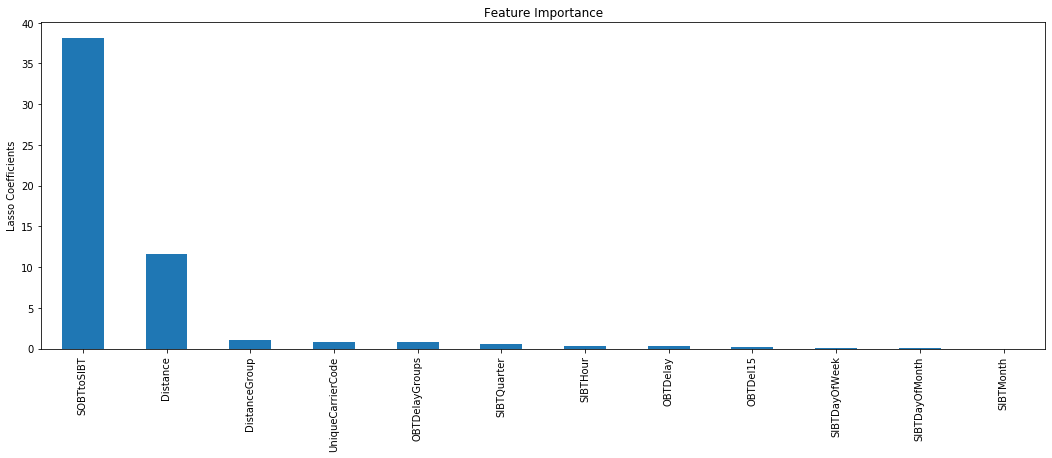

In [97]:
# Finally, just for fun, let's look at the feature importance

importance = pd.Series(np.abs(lin_model.coef_.ravel()))
importance.index = flights.iloc[:, 1:13].columns.to_list()
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(18, 6))
plt.ylabel('Lasso Coefficients')
plt.title('Feature Importance')